In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28


Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

def build_session(gpu_fraction=0.2, allow_growth=True):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=allow_growth)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


sess = build_session()
K.set_session(sess)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(128))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(64))

In [5]:
def mat_dist(input_labels,inputs,flag_l2norm=True,):
    # do softmax cross-entropy
    lshape = K.tf.shape(input_labels)
    #assert lshape.shape == 1
    labels = K.tf.reshape(input_labels, [lshape[0], 1])

    mask = K.tf.to_int32(K.tf.equal(labels, K.tf.transpose(labels)))
    positive_mask = K.tf.matrix_band_part(mask, 0, -1) - tf.matrix_band_part(mask, 0, 0)
    negative_mask = K.tf.matrix_band_part(1 - mask, 0, -1)
#     print('gcont: flag_l2norm',flag_l2norm)
    if flag_l2norm:
        inputs = K.l2_normalize(inputs,axis=1)
        
    sim = K.tf.matmul(inputs, K.tf.transpose(inputs))
    # 使其取值范围在0-1区间上，sn目标为0而sp目标为1
#     sim = (sim + 1.) / 2.
    pos_sim = tf.boolean_mask(sim, positive_mask)
    neg_sim = tf.boolean_mask(sim, negative_mask)
    
    return pos_sim, neg_sim


def circle_loss(input_labels,inputs,margin = 0.25, gamma=256):
    pos_sim, neg_sim = mat_dist(input_labels, inputs)
    ap = K.clip(- K.tf.stop_gradient(pos_sim) + 1 + margin, min_value=0., max_value=2.)
    an = K.clip(K.tf.stop_gradient(neg_sim) + margin, min_value=0., max_value=2.)
    
    delta_p = 1 - margin
    delta_n = margin

    logit_p = - ap * (pos_sim - delta_p) * gamma
    logit_n = an * (neg_sim - delta_n) * gamma
    loss = K.softplus(K.logsumexp(logit_p)+K.logsumexp(logit_n))

    return loss# K.max(an), K.min(an)

In [6]:
model.compile(loss=circle_loss,
              optimizer=keras.optimizers.SGD(),
              metrics=[])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=200,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)
# print('Test accuracy:', score[1])

## with_model evaluation

/data/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 8s 135us/step - loss: 237.5916 - val_loss: 237.5716
Epoch 2/200
60000/60000 [==============================] - 7s 115us/step - loss: 223.8533 - val_loss: 231.6416
Epoch 3/200
60000/60000 [==============================] - 7s 117us/step - loss: 202.6574 - val_loss: 231.0028
Epoch 4/200
60000/60000 [==============================] - 7s 115us/step - loss: 196.5675 - val_loss: 230.8021
Epoch 5/200
60000/60000 [==============================] - 7s 115us/step - loss: 192.7726 - val_loss: 229.0677
Epoch 6/200
60000/60000 [==============================] - 7s 115us/step - loss: 190.4645 - val_loss: 228.5386
Epoch 7/200
60000/60000 [==============================] - 7s 115us/step - loss: 188.4791 - val_loss: 226.6956
Epoch 8/200
60000/60000 [==============================] - 7s 115us/step - loss: 186.9846 - val_loss: 229.5151
Epoch 9/200
60000/60000 [==============================] - 7s 

60000/60000 [==============================] - 4s 66us/step - loss: 158.1205 - val_loss: 189.5111
Epoch 148/200
60000/60000 [==============================] - 4s 65us/step - loss: 158.7630 - val_loss: 190.2211
Epoch 149/200
60000/60000 [==============================] - 4s 65us/step - loss: 157.8352 - val_loss: 184.9723
Epoch 150/200
60000/60000 [==============================] - 4s 65us/step - loss: 157.9588 - val_loss: 189.2230
Epoch 151/200
60000/60000 [==============================] - 4s 64us/step - loss: 157.5085 - val_loss: 183.7452
Epoch 152/200
60000/60000 [==============================] - 4s 64us/step - loss: 157.7968 - val_loss: 182.9408
Epoch 153/200
60000/60000 [==============================] - 4s 67us/step - loss: 157.6236 - val_loss: 184.2920
Epoch 154/200
60000/60000 [==============================] - 4s 67us/step - loss: 157.3975 - val_loss: 181.5109
Epoch 155/200
60000/60000 [==============================] - 4s 66us/step - loss: 157.0771 - val_loss: 181.9331
Epoch 

In [7]:
clf_model = Sequential()
clf_model.add(Dense(num_classes, activation='softmax'))
clf_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

# x_batch, y_batch = model.predict(x_train[:batch_size]), keras.utils.to_categorical(y_train[:batch_size], num_classes)
# x_batch, y_batch = model.predict(x_train[:batch_size]), y_train[:batch_size]
# print(x_batch.shape, y_batch.shape)
# clf_model.train_on_batch(x_batch, y_batch)

tmp_train = model.predict(x_train)
tmp_train = tmp_train / np.linalg.norm(tmp_train, axis=1)[:, np.newaxis]
tmp_test = model.predict(x_test)
tmp_test = tmp_test / np.linalg.norm(tmp_test, axis=1)[:, np.newaxis]

clf_model.fit(tmp_train, y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(tmp_test, y_test))
score = clf_model.evaluate(tmp_test, y_test, verbose=0)
print(score)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 13us/step - loss: 2.2707 - acc: 0.2390 - val_loss: 2.2212 - val_acc: 0.3929
Epoch 2/100
60000/60000 [==============================] - 1s 11us/step - loss: 2.1754 - acc: 0.5037 - val_loss: 2.1293 - val_acc: 0.6168
Epoch 3/100
60000/60000 [==============================] - 1s 11us/step - loss: 2.0856 - acc: 0.7638 - val_loss: 2.0414 - val_acc: 0.8782
Epoch 4/100
60000/60000 [==============================] - 1s 11us/step - loss: 1.9993 - acc: 0.9280 - val_loss: 1.9567 - val_acc: 0.9519
Epoch 5/100
60000/60000 [==============================] - 1s 11us/step - loss: 1.9161 - acc: 0.9694 - val_loss: 1.8751 - val_acc: 0.9717
Epoch 6/100
60000/60000 [==============================] - 1s 11us/step - loss: 1.8359 - acc: 0.9827 - val_loss: 1.7964 - val_acc: 0.9790
Epoch 7/100
60000/60000 [==============================] - 1s 11us/step - loss: 1.7587 - acc: 0.9881 - val_loss: 1.7208 - 

KeyboardInterrupt: 

In [ ]:
mlp = Sequential()
mlp.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
mlp.add(Conv2D(64, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(pool_size=(2, 2)))
mlp.add(Dropout(rate=0.25))
mlp.add(Flatten())
mlp.add(Dense(128, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(num_classes, activation='softmax'))
mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
mlp.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = mlp.evaluate(x_test, y_test, verbose=0)

(10000, 128) <type 'numpy.ndarray'>


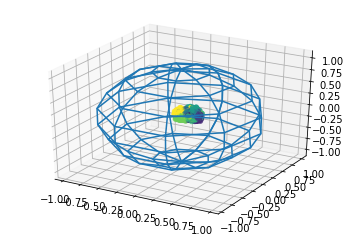

In [8]:
test = sess.run(K.l2_normalize(model.predict(x_test),axis=1))
# test = model.predict(x_test)
print(test.shape, type(test))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, np.pi, 10)
v = np.linspace(0, 2 * np.pi, 10)
x = np.outer(np.sin(u), np.sin(v))
y = np.outer(np.sin(u), np.cos(v))
z = np.outer(np.cos(u), np.ones_like(v))
ax.plot_wireframe(x, y, z)

ax.scatter(test[:,0], test[:,1],test[:,2], c=y_test)

## without_model evaluation

In [9]:
stereo_type = []
for i in range(num_classes):
    tmp_i = model.predict(x_train[y_train==i])
    tmp_i = tmp_i / np.linalg.norm(tmp_i, axis=1)[:, np.newaxis]
    tmp_i = np.mean(tmp_i, axis=0)
    stereo_type.append(tmp_i)           
stereo_type = np.array(stereo_type)

tmp_test = model.predict(x_test)
tmp_test = tmp_test / np.linalg.norm(tmp_test, axis=1)[:, np.newaxis]
label = np.argmax(np.matmul(tmp_test, stereo_type.T), axis=1)
print("acc", np.sum(y_test == label))
# stereo_type = [np.mean(model.predict(x_train[y_train==i]), axis=0) ]

acc 9891


In [10]:
pos_sim, neg_sim = sess.run(mat_dist(y_train[:batch_size], model.predict(x_train[:batch_size])))
print(np.mean(pos_sim), np.mean(neg_sim))

0.8886915 0.65426034


In [11]:
y_train.shape

(60000,)